# Classification workflow:

1) Load and normalize (by Standard and MinMax sclaer) all protocol data

2) Segregate spectra and extract features: segment duration=5.12sec, data length after flattening=16070

3) Train-validation-test split

4) PCA: figure out the number of component to keep by using train and validation set

5) PCA transformation

6) Logistic Regression Classification: do grid-search to optimize the classifier parameter

7) SVM Classification: do grid-search to optimize the classifier parameter

In [12]:
import numpy as np
import DataProcess as DP
import FeatureCalculate as FC
import DataProcessForPCA as DPpca
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC

## 1) Load and Normalize Data:

In [2]:
# Use StandardScaler:
specchunks=[]
for i in DP.protocol_list:
    X_std, specchunk = DPpca.preprocess(i, 1000, rescale=True, scaler='standard')
    specchunks.append(np.array(specchunk))

# Use MinMaxScaler:
specchunks2=[]
for i in DP.protocol_list:
    X_std, specchunk2 = DPpca.preprocess(i, 1000, rescale=True, scaler='minmax')
    specchunks2.append(np.array(specchunk2))

## 2) Data segmentation + Feature extraction + Flattening:

In [3]:
chunks=[]
for i in range(len(specchunks)):
    chunks.append(DPpca.segmentation(specchunks[i],T=512,stride=512))

chunks2=[]
for i in range(len(specchunks2)):
    chunks2.append(DPpca.segmentation(specchunks2[i],T=512,stride=512))

In [9]:
for i in range(len(chunks)):
    print(chunks[i].shape)

(426, 16070)
(453, 16070)
(292, 16070)
(399, 16070)
(472, 16070)
(432, 16070)
(398, 16070)
(450, 16070)
(8, 16070)


## 3) Train-validation-test split (0.7: 0.12: 0.18)

In [5]:
# Stack data from different subjects into one chunk:
data = np.vstack(chunks)
data2 = np.vstack(chunks2)

#shuffle data
np.random.shuffle(data)
np.random.shuffle(data2)

X = data[:,:-1]
y = data[:,-1]
X2 = data2[:,:-1]
y2 = data2[:,-1]

In [6]:
# Calculate class_weight of activities:
actID, counts = np.unique(y, return_counts=True)
weight = counts/np.sum(counts)
act_weight = dict(zip(actID, weight))
act_weight

{1.0: 0.10270270270270271,
 2.0: 0.097897897897897893,
 3.0: 0.1012012012012012,
 4.0: 0.12912912912912913,
 5.0: 0.049849849849849852,
 6.0: 0.087687687687687685,
 7.0: 0.1012012012012012,
 12.0: 0.047447447447447451,
 13.0: 0.039339339339339342,
 16.0: 0.092192192192192199,
 17.0: 0.12912912912912913,
 24.0: 0.022222222222222223}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.18, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.12, random_state=42)

## 4) PCA: find out ideal n_components by using train and validation set

**Eigen-values:**

In [10]:
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

cov_mat2 = np.cov(X2_train.T)
eig_vals2, eig_vecs2 = np.linalg.eig(cov_mat2)

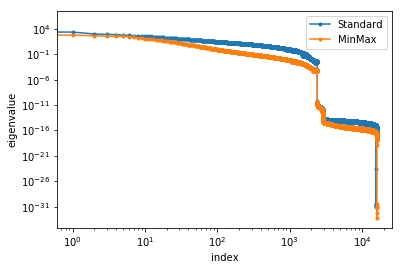

In [11]:
n = len(np.abs(eig_vals))
plt.plot(np.linspace(0, n-1, n), np.abs(eig_vals), label='Standard', marker='o', ms=3)
plt.plot(np.linspace(0, n-1, n), np.abs(eig_vals2), label='MinMax', marker='o', ms=3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.legend();

### Scree plot:

In [13]:
pca = PCA().fit(X_train)
pca2 = PCA().fit(X2_train)

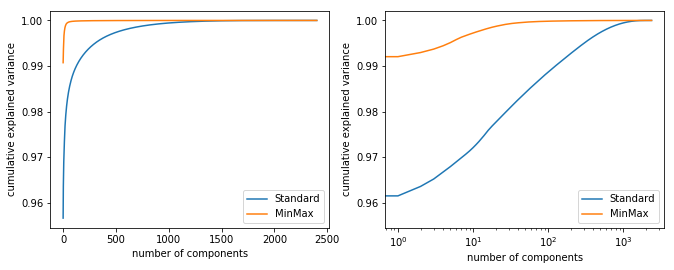

In [14]:
plt.figure(figsize=[11, 4])
plt.subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Standard')
plt.plot(np.cumsum(pca2.explained_variance_ratio_), label='MinMax')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()

plt.subplot(122)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Standard')
plt.plot(np.cumsum(pca2.explained_variance_ratio_), label='MinMax')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xscale('log')
plt.legend();

### Find optimal n_components:

In [15]:
train_scores = []
train_scores2 = []
val_scores = []
val_scores2 = []
components = [2,4,6,8,10,15,20,25,40,70,100,150,200,300,400,500,600]
for i in components:
    pca = PCA(n_components=i)
    pca2 = PCA(n_components=i)
    X_tr = pca.fit_transform(X_train)
    X2_tr = pca2.fit_transform(X2_train)
    X_v = pca.transform(X_val)
    X2_v = pca2.transform(X2_val)
    
    # Use parameters from Kathryn's test:
    cls = LogisticRegression(penalty='l1', C=30, class_weight=act_weight)
    cls2 = LogisticRegression(penalty='l1', C=30, class_weight=act_weight)
    cls.fit(X_tr,y_train)
    cls2.fit(X2_tr,y2_train)
    train_scores.append(cls.score(X_tr,y_train))
    train_scores2.append(cls2.score(X2_tr,y2_train))
    val_scores.append(cls.score(X_v,y_val))
    val_scores2.append(cls2.score(X2_v,y2_val))

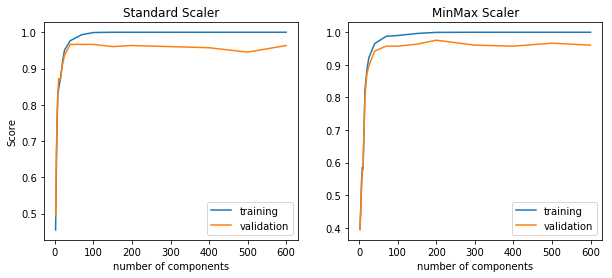

In [16]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.plot(components, train_scores, label='training')
plt.plot(components, val_scores, label='validation')
plt.xlabel('number of components')
plt.ylabel('Score')
plt.title('Standard Scaler')
plt.legend()

plt.subplot(122)
plt.plot(components, train_scores2, label='training')
plt.plot(components, val_scores2, label='validation')
plt.xlabel('number of components')
plt.title('MinMax Scaler')
plt.legend()
plt.show()

In [18]:
print('Optimal n_components & validation score:')
n1 = components[np.argmax(val_scores)]
n2 = components[np.argmax(val_scores2)]
print('Standard Scaler: {},\tScore = {}'.format(components[np.argmax(val_scores)], val_scores[np.argmax(val_scores)]))
print('MinMax Scaler:{},\tScore = {}'.format(components[np.argmax(val_scores2)], val_scores2[np.argmax(val_scores2)]))

Optimal n_components & validation score:
Standard Scaler: 40,	Score = 0.9664634146341463
MinMax Scaler:200,	Score = 0.975609756097561


**MinMax scaler needs more components than standard scaler.**

## 5) PCA Transformation: 

In [19]:
pca = PCA(n_components=n1)
X_train_pca = pca.fit_transform(np.vstack((X_train, X_val)))
X_test_pca = pca.transform(X_test)
y_train_pca = np.append(y_train, y_val)

pca2 = PCA(n_components=n2)
X2_train_pca = pca2.fit_transform(np.vstack((X2_train, X2_val)))
X2_test_pca = pca2.transform(X2_test)
y2_train_pca = np.append(y2_train, y2_val)

## 6) Logistic Regression:

**Quick peek: Test score of using logistic regression is 0.9517 (Standard) and 0.9783 (MinMax).**

### Grid Search Parameters:
**Standard Scaler:**

In [20]:
# Set up the hyperparameter parameterspace
logreg_param_grid = {'C': [0.1, 0.3, 1, 3, 10], 
                     'penalty' : ["l1", "l2"],
                     'class_weight': ["balanced", act_weight, None]}

In [21]:
logreg = LogisticRegression()
logreg_gs = GridSearchCV(logreg, logreg_param_grid, cv=5)
%time logreg_gs.fit(X_train_pca, y_train_pca)

Wall time: 3min 35s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 1, 3, 10], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print("Optimal Parameters: {}".format(logreg_gs.best_params_))
print("Best score: {}".format(logreg_gs.best_score_))

Optimal Parameters: {'C': 0.3, 'class_weight': 'balanced', 'penalty': 'l1'}
Best score: 0.9538461538461539


In [23]:
y_pred_log = logreg_gs.predict(X_test_pca)
print('test score=', logreg_gs.score(X_test_pca, y_test))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

test score= 0.951666666667
[[58  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 55  2  0  0  0  0  0  0  0  0  0]
 [ 0  3 56  0  0  0  0  0  0  0  3  0]
 [ 0  0  0 82  0  0  2  0  1  0  1  0]
 [ 0  0  0  0 29  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 38  1  0  0  1  0  0]
 [ 0  0  0  1  0  0 61  3  0  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  1  0  0]
 [ 0  0  0  0  0  0  1  0 23  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 51  5  0]
 [ 0  0  0  0  0  0  0  0  0  1 80  0]
 [ 1  0  0  0  1  0  0  0  0  0  0 15]]
             precision    recall  f1-score   support

        1.0       0.97      1.00      0.98        58
        2.0       0.95      0.95      0.95        58
        3.0       0.97      0.90      0.93        62
        4.0       0.99      0.95      0.97        86
        5.0       0.97      1.00      0.98        29
        6.0       1.00      0.95      0.97        40
        7.0       0.94      0.94      0.94        65
       12.0       0.88      0.96      0.92        24
       13.0       0.96    

**MinMax Scaler:**

In [24]:
logreg = LogisticRegression()
logreg_gs2 = GridSearchCV(logreg, logreg_param_grid, cv=5)
%time logreg_gs2.fit(X2_train_pca, y2_train_pca)

Wall time: 15min 29s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 1, 3, 10], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
print("Optimal Parameters: {}".format(logreg_gs2.best_params_))
print("Best score: {}".format(logreg_gs2.best_score_))

Optimal Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
Best score: 0.9681318681318681


In [26]:
y2_pred_log = logreg_gs2.predict(X2_test_pca)
print('test score=', logreg_gs2.score(X2_test_pca, y2_test))
print(confusion_matrix(y2_test, y2_pred_log))
print(classification_report(y2_test, y2_pred_log))

test score= 0.978333333333
[[62  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 48  3  0  0  0  0  0  0  1  0  0]
 [ 0  1 46  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 77  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 52  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 23  0  0  0]
 [ 0  0  0  0  0  0  0  2  0 64  2  0]
 [ 0  1  0  0  0  0  0  0  0  0 84  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        62
        2.0       0.96      0.92      0.94        52
        3.0       0.92      0.98      0.95        47
        4.0       0.99      1.00      0.99        77
        5.0       0.97      0.97      0.97        34
        6.0       1.00      1.00      1.00        52
        7.0       1.00      1.00      1.00        52
       12.0       0.94      0.97      0.95        31
       13.0       1.00    

## 7) SVM:
**Quick peek: Test score of using SVM is 0.9817 (Standard) and 0.9867 (MinMax).**

### Grid Search Parameters:
**Standard Scaler:**

In [27]:
# Set up the hyperparameter parameterspace
svm_param_grid = {'C': [0.05, 0.1, 0.3, 0.5, 1], 
                  'kernel' : ["linear", "poly"],
                  'tol': [1, 5e-1, 3e-1, 1e-1, 3e-2, 1e-2],
                  'class_weight': ["balanced", act_weight, None]}

In [28]:
svm = SVC()
svm_gs = GridSearchCV(svm, svm_param_grid, cv=5)
%time svm_gs.fit(X_train_pca, y_train_pca)

Wall time: 2min 4s


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.3, 0.5, 1], 'kernel': ['linear', 'poly'], 'tol': [1, 0.5, 0.3, 0.1, 0.03, 0.01], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
print("Optimal Parameters: {}".format(svm_gs.best_params_))
print("Best score: {}".format(svm_gs.best_score_))

Optimal Parameters: {'C': 0.05, 'class_weight': {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, 'kernel': 'linear', 'tol': 0.1}
Best score: 0.9787545787545787


In [30]:
y_pred_svm = svm_gs.predict(X_test_pca)
print('test score=', svm_gs.score(X_test_pca, y_test))
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

test score= 0.981666666667
[[58  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 56  2  0  0  0  0  0  0  0  0  0]
 [ 0  0 60  0  0  0  0  0  0  0  2  0]
 [ 0  0  0 85  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 65  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  1  0  0]
 [ 0  0  0  1  0  1  0  0 22  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 55  0  0]
 [ 0  0  0  0  0  0  0  0  0  2 79  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        58
        2.0       0.98      0.97      0.97        58
        3.0       0.97      0.97      0.97        62
        4.0       0.99      0.99      0.99        86
        5.0       1.00      1.00      1.00        29
        6.0       0.98      1.00      0.99        40
        7.0       1.00      1.00      1.00        65
       12.0       1.00      0.96      0.98        24
       13.0       0.96    

**MinMax Scaler:**

In [31]:
svm = SVC()
svm_gs2 = GridSearchCV(svm, svm_param_grid, cv=5)
%time svm_gs2.fit(X2_train_pca, y2_train_pca)

Wall time: 10min 46s


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.3, 0.5, 1], 'kernel': ['linear', 'poly'], 'tol': [1, 0.5, 0.3, 0.1, 0.03, 0.01], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
print("Optimal Parameters: {}".format(svm_gs2.best_params_))
print("Best score: {}".format(svm_gs2.best_score_))

Optimal Parameters: {'C': 0.05, 'class_weight': {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, 'kernel': 'linear', 'tol': 0.3}
Best score: 0.9769230769230769


In [33]:
y2_pred_svm = svm_gs2.predict(X2_test_pca)
print('test score=', svm_gs2.score(X2_test_pca, y2_test))
print(confusion_matrix(y2_test, y2_pred_svm))
print(classification_report(y2_test, y2_pred_svm))

test score= 0.986666666667
[[62  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  2  0  0  0  0  0  0  0  0  0]
 [ 0  2 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 77  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 52  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 66  2  0]
 [ 0  0  0  0  0  0  0  0  0  0 85  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 15]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        62
        2.0       0.96      0.96      0.96        52
        3.0       0.96      0.96      0.96        47
        4.0       1.00      1.00      1.00        77
        5.0       1.00      1.00      1.00        34
        6.0       1.00      1.00      1.00        52
        7.0       0.98      1.00      0.99        52
       12.0       1.00      0.97      0.98        31
       13.0       0.96    